<a href="https://colab.research.google.com/github/sahar-felehgari/Detection-and-segmentation-boats-and-the-sea-in-image-with-Fast-RCNN/blob/main/final_boat_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

conecte to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os

num_boat_train = len(os.listdir('/content/drive/MyDrive/boat/train/boat'))
num_withoutboat_train = len(os.listdir('/content/drive/MyDrive/boat/train/without boat'))
num_boat_validation = len(os.listdir('/content/drive/MyDrive/boat/validation/validation/boat'))
num_withoutboat_validation = len(os.listdir('/content/drive/MyDrive/boat/validation/validation/without boat'))
num_test = len(os.listdir('/content/drive/MyDrive/boat/test/main data-test'))

print(f'Train: boat: {num_boat_train} | without_boat: {num_withoutboat_train}')
print(f'Validation: boat: {num_boat_validation} | without_boat: {num_withoutboat_validation}')
print(f'Test: {num_test}')

Train: boat: 3856 | without_boat: 911
Validation: boat: 1012 | without_boat: 108
Test: 1974


In [ ]:
import numpy as np
import cv2
img= cv2.imread(r'/content/drive/MyDrive/boat/train/boat/20130304_054052_03905.jpg')
print("shape:", img.shape)

shape: (240, 800, 3)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
   '/content/drive/MyDrive/boat/train',
    image_size=(240, 800),
    label_mode='binary',
    labels='inferred',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
   '/content/drive/MyDrive/boat/validation/validation',
    image_size=(240, 800),
    label_mode='binary',
    labels='inferred',
    batch_size=32)
#test_dataset = image_dataset_from_directory(
    #os.path.join(new_base_dir, 'maskdata/test'),
    #image_size=(180, 180),
    #label_mode='binary',
    #labels='inferred',
    #batch_size=16)

Found 4767 files belonging to 2 classes.
Found 1120 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 240, 800, 3)
labels batch shape: (32, 1)


#model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(240, 800, 3))
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(240, 800, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 800, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 240, 800, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 798, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 399, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 397, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 198, 64)      0         
 2D)                                                         

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        #layers.RandomHeight(0.1,0.2),
        layers.RandomZoom(0.2),
        #layers.RandomHeight(0.2,0.3),
        layers.RandomRotation(0.1),
        #layers.RandomBrightness(factor=0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(240, 800, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
    ]

#training

In [ ]:
history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/2
149/149 [==============================] - 11922s 80s/step - loss: 7.0291 - accuracy: 0.9761 - val_loss: 10.6343 - val_accuracy: 0.9714
Epoch 2/2
 93/149 [=================>............] - ETA: 59:59 - loss: 3.4889 - accuracy: 0.9886  

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
def input_picture():
 from google.colab import files
 myfile = files.upload()
 return (myfile)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
def img_to_array (myfile):
 img_path = next(iter(myfile))
 img = image.load_img(img_path, target_size=(240, 800))
 x = image.img_to_array(img)
 x = np.expand_dims(x, axis=0)
 x = keras.applications.vgg16.preprocess_input(x)
  #return(img)
 return (x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import keras
from tensorflow.keras.preprocessing import image
def img_to_array2 (myfile):
 img_path = next(iter(myfile))
 img = image.load_img(img_path, target_size=(240, 800))
 x = image.img_to_array(img)
 x = np.expand_dims(x, axis=0)
 x = keras.applications.vgg16.preprocess_input(x)
 return(img)
 #return (x)

In [ ]:
def pred_model (x):
 test_model = keras.models.load_model('feature_extraction_with_data_augmentation.keras')
 pred = test_model.predict(x)
 return(pred)


In [ ]:
def recognition (pred,img):
 img=plt.imshow(img)
 plt.axis("off")
 if pred<0.5:
     plt.title('boat')
 else:
     plt.title('withoutboat')
 return(pred,img)

In [ ]:
def main():
 myfile=input_picture()
 x = img_to_array(myfile)
 img = img_to_array2(myfile)
 pred=pred_model(x)
 recognition (pred,img)

Saving 20130412_043430_55283.jpg to 20130412_043430_55283 (2).jpg


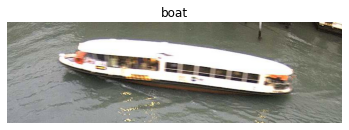

In [ ]:
main()

In [ ]:
answer =input(print('Do you wanna upload another photo?  y/n'))
while answer =='y':
    myfile =input_picture()
    main(myfile)
    answer =input(print('Do you wanna upload another photo?  y/n'))
else:
    print("c")


Do you wanna upload another photo?  y/n
Noney


NameError: ignored